# 1.1 PSSM generation

Generate PSSM files to extract evolutionary features. Using Mmseqs the process can be really fast.  

However, I have found a problem (I don't know if it is an bug or not) in the program and created an issue to the Mmseqs team. So at the moment it is down.

In [1]:
from BioML.utilities.utils import MmseqsClustering

In [29]:
fasta_file = "../data/whole_sequence.fasta"

In [3]:
pssm_file = MmseqsClustering.easy_generate_pssm(input_file=fasta_file, database_input=fasta_file,
output_database="../data/whole_sequence", generate_searchdb=True, pssm_filename="esterase.pssm")

start running createdb
It took 0.008338212966918945 second to run
start running search
It took 2.8009424209594727 second to run
start running generate_profile
It took 0.08434319496154785 second to run
start running convert profile to pssm
It took 0.04231381416320801 second to run


In [4]:
MmseqsClustering.split_pssm(pssm_file)

# 1.2 Extract Features

There are several features to extract:
   1. Physicochemical features from iFeatures https://github.com/Superzchen/iFeature
   2. It might be great to incorporate other features the Lab is using like the Onehot encoding and the AA index
   3. Evolutionary features using PSSM and Possum https://possum.erc.monash.edu/
   4. Features or embeddings from Large language models 

Before substrate extraction you might want to clean the fast file of non canonical residues like X, U, B etc and to remove those shorter than 100 aamino acids for example

In [21]:
from BioML.features.extraction import PossumFeatures, IfeatureFeatures, read_features
from BioML.utilities.utils import clean_fasta

In [5]:
clean_fasta("/home/ruite/Projects/enzyminer/POSSUM_Toolkit", fasta_file, "cleaned.fasta", 100)
fasta_file = "cleaned.fasta"

Success!
The sequences shorter than 100 will be removed!
Success!


In [18]:
ifeatures = IfeatureFeatures("/home/ruite/Projects/enzyminer/iFeature")
ifeatures.extract(fasta_file)

iFeature features to be extracted: {'long': ['NMBroto', 'Moran', 'Geary'], 'short': ['CKSAAGP', 'PAAC', 'CTDD', 'GDPC', 'APAAC', 'GAAC', 'GTPC', 'SOCNumber', 'CTDT', 'KSCTriad', 'CTDC', 'CTriad', 'QSOrder']}


start running Ifeature programs
It took 16.37057065963745 second to run


In [4]:
possum = PossumFeatures(pssm_dir="pssm", program="/home/ruite/Projects/enzyminer/POSSUM_Toolkit")
possum.extract(fasta_file)

Possum features to be extracted: {'long': ['tri_gram_pssm', 'pssm_cc'], 'short': ['edp', 'd_fpssm', 'rpssm', 'pssm_ac', 'pssm_composition', 'pse_pssm:2', 's_fpssm', 'pse_pssm:3', 'tpc', 'aac_pssm', 'smoothed_pssm:7', 'k_separated_bigrams_pssm', 'eedp', 'ab_pssm', 'smoothed_pssm:5', 'smoothed_pssm:9', 'dpc_pssm', 'rpm_pssm', 'dp_pssm', 'pse_pssm:1']}
start running Possum programs
It took 494.46776008605957 second to run


# 1.3  LLM embeddings

If you want you can easily generate large language model embeddings from models supported by Hugging Face's API

In [2]:
from BioML.deep import embeddings

In [4]:
embeddings.generate_embeddings(fasta_file, model_name="facebook/esm2_t6_8M_UR50D", option="mean", save_path="embeddings.csv", mode="write")

# 2 Feature selection

If we combine features from multiple places the dimensions would be too high to handle, so normally ti would be wise to use some feature selection techniques:BioML implements at the moment 8 algorithms for classification and 6 for regression 
 
    1. Supervised: using Tree methods Random Forest and Xgboost, Recursive feature elmination
    2. Filter methods: Pearson correlation, Chi squared,
    3. TODO: Unsupervised methods like: PCA, ICA (independent component analysis)

In [1]:
import pandas as pd
from BioML.features import selection
from BioML.features.extraction import read_features

In [5]:
ifeat = read_features("ifeature", ifeature_out="ifeature_features", file_splits=1)
possum_feat = read_features("possum", possum_out="possum_features", file_splits=1, index=ifeat.index)
emb = pd.read_csv("embeddings.csv", index_col=0)

In [23]:
emb.columns.shape, ifeat.columns.shape, possum_feat.columns.shape

((320,), (2274,), (18730,))

The DataReader function takes:
* label in different formats: string, ndarray, a list of pd.Series.
* It also takes features in different formats: a list, ndarray, dataframe, list of dataframes or a list of the different accepted formats and concatenates them

It will automatically remove features with 0 variance (meaning every value is the same), you can control the threshold

In [6]:
features = selection.DataReader("../data/esterase_labels.csv", [ifeat, possum_feat], variance_thres=0.005)
features

Data with:
    num. samples: 147
    num. columns: 6907
    variance threshold: 0.005
    sheet: None

### Custom splitting based on 30% sequence identity

It is recommended to split based on sequence identity so that the training, test or validation sets doesn't have sequence with more than 30% sequence identity.
You can use mmseqs to generate such clusters

In [2]:
from BioML.utilities.utils import MmseqsClustering
from BioML.utilities.split_methods import ClusterSpliter
from BioML.models.base import DataParser
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

### Generate different clusters of sequences based on an identity threshold of 30%.
It creates a cluster.tsv file. This tsv file has the first column the clusters names (which should be the same one as the features indices) and in the second column the idex of the sequence that resides within that cluster.  

For example: This means EH2(71) is a cluster with 3 sequences that share more than 30% sequence identity.

* EH2(71)	EH2(71)
* EH2(71)	EH4(67)
* EH2(71)	EH14(48)

This technique is actually very flexible, you can generate manually a cluster file if you want to customize the way you want to split your data into training and testing splits

In [30]:
cluster = MmseqsClustering.easy_cluster(fasta_file, cluster_at_sequence_identity=0.3)

start running cluster
It took 0.0037527084350585938 second to run
start running create tsv
It took 0.05854964256286621 second to run


Now split based on this sequence identity cluster, the clusters names can be strings or numbers as long as it is the same as the index of feautures dataframe.  
But if they are different, cluster names are different to the index of the dataframe, there is an additional groups argument in the split and train_test_split function that accepts a list with the names present in the cluster file and ordered as the rows in the dataframe

In [7]:
split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
X_train, X_test, y_train, y_test = split.train_test_split(features.features, features.label)

In [32]:
X_train

,CHAM820101.lag24_Geary,CHOC760101.lag24_Geary,BIGC670101.lag24_Geary,CHAM810101.lag23_Geary,CHAM820101.lag1_NMBroto,CHAM820101.lag6_NMBroto,CHAM820101.lag13_NMBroto,CHAM820101.lag14_NMBroto,CHAM820101.lag15_NMBroto,CHAM820101.lag20_NMBroto,...,s_fpssm390,s_fpssm391,s_fpssm392,s_fpssm393,s_fpssm394,s_fpssm395,s_fpssm396,s_fpssm397,s_fpssm398,s_fpssm399
#,,,,,,,,,,,,,,,,,,,,,
EH111(8),1.016057,1.022939,1.009556,1.203009,-0.004050,-0.016813,0.004004,0.029777,-0.019283,0.117136,...,27.0,0.0,5.0,3.0,11.0,0.0,2.0,15.0,8.0,46.0
EH15(42),1.167139,1.159859,1.183571,1.054979,0.210418,0.139457,0.167311,0.220085,0.212778,0.196873,...,20.0,3.0,15.0,11.0,11.0,1.0,6.0,6.0,7.0,71.0
EH117(6),1.000051,0.989300,1.010810,1.049855,0.021633,0.060085,0.096981,0.110730,0.088660,-0.027230,...,38.0,5.0,18.0,17.0,4.0,2.0,5.0,10.0,12.0,61.0
EH11(53),1.155337,1.158283,1.144786,1.076079,0.215108,0.120346,0.227989,0.293609,0.149229,0.199208,...,31.0,2.0,14.0,14.0,11.0,2.0,9.0,0.0,1.0,93.0
EH135(2),0.954970,0.953658,0.921358,1.020049,0.058143,0.089392,0.081488,0.039703,0.140493,-0.016214,...,10.0,4.0,8.0,27.0,6.0,2.0,5.0,30.0,22.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EH86(13),1.118555,1.122978,1.146220,1.067694,0.113712,0.122434,0.180717,0.191214,0.146294,0.137896,...,24.0,0.0,15.0,10.0,6.0,1.0,5.0,6.0,8.0,66.0
EH102(10),1.024055,0.994123,0.983951,1.036248,0.078662,0.090576,0.017300,0.057238,0.043014,0.077007,...,22.0,2.0,7.0,6.0,5.0,3.0,6.0,1.0,5.0,59.0
EH66(19),1.027011,1.043370,1.031698,0.943373,0.038165,0.015982,0.027990,0.008226,-0.018514,0.074816,...,29.0,0.0,16.0,7.0,2.0,0.0,5.0,12.0,10.0,57.0



The get_range_features retuns a list of feature dimensions to extract and it will generate an excel file with those features, the number of sheets will be len(feature_range) * number of selection algorithms

It will also output an plot of the feature importance with the shap package https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

Using the scores from Xgboost using the columns from the maximum feature range.
The selection is not repeated for each feature range except for the RFE.   
Because the columns are sorted by importance, so I just get [:feature range]

In [33]:
problem ="classification"
feature_range = selection.get_range_features(features.features, num_features_min = 20, num_features_max=60, step_range=10)
feature_range

[20, 30, 40, 50, 60]

27-05-2024 18:57:32 INFO Reading the features
27-05-2024 18:57:32 INFO Starting feature selection and using the following parameters
27-05-2024 18:57:32 INFO seed: 10
27-05-2024 18:57:32 INFO filtering the features


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 20 dimensions
generating a feature set of 30 dimensions
generating a feature set of 40 dimensions
generating a feature set of 50 dimensions
generating a feature set of 60 dimensions


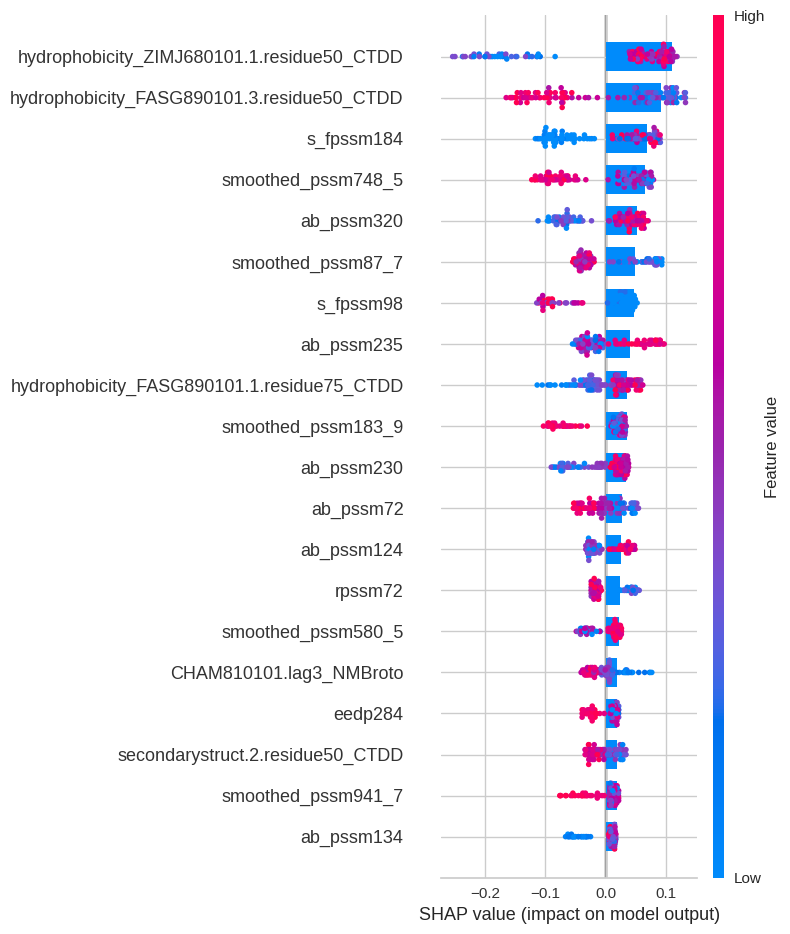

In [34]:
# select features
if problem == "classification":
    filters = selection.FeatureClassification()
elif problem == "regression":
    filters = selection.FeatureRegression()

select = selection.FeatureSelection("classification_results/filtered_features.xlsx", filters, num_thread=2, seed=10, 
                                    scaler="robust", test_size=0.2)

select.construct_features(features.features, X_train, y_train, feature_range)

# 4. Outlier detection

You can also eliminate outliers in your dataset which could decrease model performance.
Although, generally, if you have a lot of data outliers won't matter much.  
It is unsupervised so it only needs the features. It accepts the following formats

1. excel files
2. Pandas dataframe
3. Series, ndarray
4. csv file

It leverages 8 different outlier detection algorithms and gives you a voting. 
If you give it an excel file where there are different sheets. It will iterate through all of them.

In [12]:
from BioML.utilities.outlier import OutlierDetection

In [13]:
detection = OutlierDetection("classification_results/filtered_features.xlsx", output="classification_results/outliers.csv", num_thread=4)
outliers = detection.run()

using random_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.5s finished


using rfe_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using rfe_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using rfe_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using rfe_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_60 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_20 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_30 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using rfe_40 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_50 for outlier calculations
saving the outlier file


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [14]:
outliers.head(20)

#
EH46(23)     258
EH125(4)     195
EH89(13)     176
EH102(10)    144
EH51(22)     132
EH75(16)     125
EH121(5)     111
EH138(2)     106
EH49(23)     103
EH97(11)     102
EH71(18)      95
EH130(2)      91
EH139(2)      87
EH106(9)      76
EH93(12)      67
EH64(20)      65
EH84(13)      63
EH101(11)     54
EH115(8)      51
EH111(8)      46
dtype: int64

# 5. Model Training: Classification

In [8]:
from BioML.models.classification import Classifier
from BioML.models.regression import Regressor
from BioML.models.base import PycaretInterface, Trainer, DataParser
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np
from BioML.utilities.utils import write_results
from sklearn.linear_model import PassiveAggressiveClassifier

### We first read the data and create train and test set based on the sequence identity threshold
The DataParser returns a dataframe with the labels as a column in the same dataframe, which is why we don't need the y_train and the y_test.
This is how Pycaret likes it (the library used by BioML to train machine learning models) 

Here I'm only using one of the sheets for this example, but we don't know which of the sheets would perform better so we might need to iterate through the sheets, train the models and collect the performance for each sheet.

In [9]:
data = DataParser("classification_results/filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_60")
data = DataParser("../data/esterase_features.xlsx", "../data/esterase_labels.csv", sheets="ch2_20")
split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
X_train, X_test, _, _ = split.train_test_split(data.features, data.features[data.label])

In [6]:
X_train.head()

,hydrophobicity_FASG890101.2.residue25,alphaticr.negativecharger.gap5,BHAR880101.lag9_moran,tri_gram_pssm7077,tri_gram_pssm286,tri_gram_pssm466,tri_gram_pssm3493,tri_gram_pssm1298,tri_gram_pssm5728,tri_gram_pssm7468,tri_gram_pssm1297,tri_gram_pssm4023,tri_gram_pssm3159,tri_gram_pssm7678,tri_gram_pssm7234,tri_gram_pssm5801,tri_gram_pssm5367,tri_gram_pssm7177,target
EH111(8),19.762846,0.040486,0.084414,0.002188,0.051697,0.048276,0.016844,0.004625,0.018720,0.010066,0.001115,0.088146,0.019392,0.030169,0.035476,0.080685,0.070774,0.001775,0
EH15(42),26.279863,0.052265,-0.051729,0.010338,0.573238,0.169123,0.121183,0.019340,0.333862,0.171416,0.006026,0.451274,0.081755,0.229442,0.082068,0.262047,0.289476,0.006036,1
EH117(6),25.267666,0.036876,-0.027442,0.007047,0.075657,0.082276,0.037046,0.010299,0.030363,0.023863,0.003769,0.188441,0.026338,0.058306,0.080121,0.122729,0.022790,0.009361,0
EH11(53),19.032258,0.032895,0.042455,0.065163,0.875810,0.447033,0.195845,0.096829,0.513410,0.182430,0.031378,0.635770,0.265902,0.460689,0.281517,0.613932,0.404746,0.028915,1
EH135(2),24.555160,0.047273,0.035283,0.004763,0.053927,0.031520,0.007024,0.005613,0.022906,0.011953,0.005436,0.069167,0.018054,0.040943,0.023389,0.035671,0.049431,0.004665,0


There are 3 classes important for training machine learning models in BioML. 

1. The pycaretInterface which provides a thin layer between pycaret and BioML.
2. Classifer or Regressor claases which has the training arguments
3. Then the Trainer class that takes both classes to perform classification or regression task.

This modularity is similar to other machine learning framewoeks like pytorch-lightning and Hugging Face

I recommend learning more about pycaret since it does many things: https://pycaret.readthedocs.io/en/latest/

Currently there are 19 supported models, but you can supply your custom models as well as long as it is compatible with the scikit learn API. A fit and a predict or predict_proba methods 

In [16]:
problem = "classification"
passive = PassiveAggressiveClassifier()

In [17]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=3, 
                                  output_path="classification_results", optimize="MCC")
if problem == "classification":
    args = Classifier(optimize="MCC", drop=(), selected=(), add=(passive), plot=("learning", "confusion_matrix", "class_report"))
elif problem == "regression":
    args = Regressor(optimize="RMSE", drop=(), selected=(), add=(), plot=("learning", "residuals", "error"))

training = Trainer(experiment, args, num_splits=5, test_size=0.2,  num_iter=50, cross_validation=True)

28-05-2024 15:49:16 INFO ------------------------------------------------------------------------------
28-05-2024 15:49:16 INFO PycaretInterface parameters
28-05-2024 15:49:16 INFO Seed: 250
28-05-2024 15:49:16 INFO Budget time: 20
28-05-2024 15:49:16 INFO The number of models to select: 3
28-05-2024 15:49:16 INFO Output path: classification_results
28-05-2024 15:49:16 INFO ----------------Trainer inputs-------------------------
28-05-2024 15:49:16 INFO Number of kfolds: 5
28-05-2024 15:49:16 INFO Number of retuning iterations: 50
28-05-2024 15:49:16 INFO Test size: 0.2


Here we pass the custom spliting class if we want to perform cross validation using the same sequence identity criteria.
If the sequence identity threshold is important random cross validation would not be valid as well.

You can create your own custing spliting class as long as it is compatible with CV generator in scikit-learn

You can can also deactivate cross validation set cross_validation=False during the Trainer class instantiation. Then the metrics will be evaluated on the test set

The results is a nested dictionary with the results for the different models, ensemble of models and stacking of the models.

The models is another nested dictionary with the trained models


In [18]:
results, models = training.generate_training_results(X_train, data.label, tune=True, test_data=X_test, fold_strategy=split)

28-05-2024 15:49:25 INFO --------------------------------------------------------
28-05-2024 15:49:25 INFO Training classification models
28-05-2024 15:49:25 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy', PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)]
28-05-2024 15:49:25 INFO The number of models used 20
28-05-2024 15:49:25 INFO Time budget is 20 minutes
28-05-2024 15:49:28 INFO Model knn trained in 0.057 minutes
28-05-2024 15:49:31 INFO Model mlp trained in 0.047 minutes
28-05-2024 15:49:32 INFO Model dt 

Pycaret also generates different plots for the models it trains, like learning curves, validation curves, Precision Recall Curve, AUC etc: 
You can add more plots by modifying the plots argument in the classifier or regressor class

You can see the full list of plots here: https://pycaret.readthedocs.io/en/stable/api/classification.html#pycaret.classification.plot_model

Let's explain the 3 plots that I included by default for the classification: ("learning", "confusion_matrix", "class_report")
For regression these are the 3 plots: ("residuals", "error", "learning")
Here is an example learning curve plot.

You can access directly the pycaret class and play with it like this

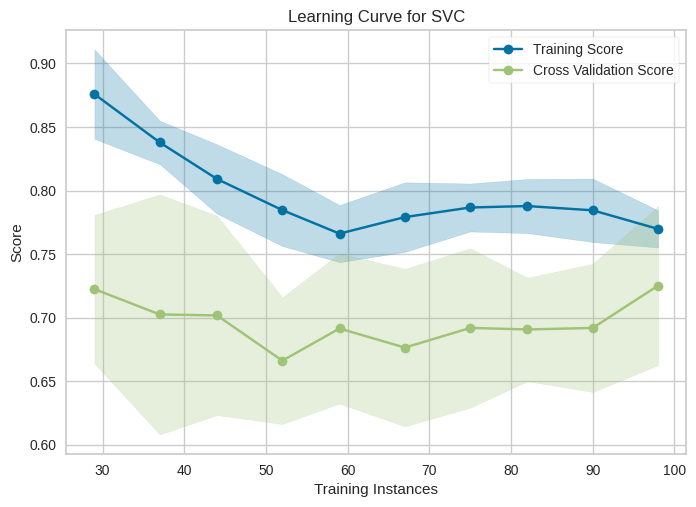

In [19]:
experiment.pycaret.plot_model(models["not_tuned"]["train"]["rbfsvm"], "learning")

Then if we want we can generate the predictions for the test or holdout set by providing with the trained models and finally 
we save both the training and the test set results

Looking at the results we can find out which models have performed well and see how we could combine them. Currently it combines automatically teh best 3 but that might not be the best approach.

In [20]:
test_set_predictions = training.generate_holdout_prediction(models)

In [21]:
training_output = "classification_results"
l = []
for tune_status, result_dict in results.items():
    for key, value in result_dict.items():
        write_results(f"{training_output}/{tune_status}", *value, sheet_name=key)
    write_results(f"{training_output}/{tune_status}", test_set_predictions[tune_status] , sheet_name=f"test_results")

This is an example of using one feature set, but if you had various features sets that you want to test you could use iterate_excel from the utilities and the iterate_multiple_features method from Trainer.

The method accepts an iterator of (feature dataframe, label column name, name): 
    1. name is used to identify the features later in the results
    2. feature dataframe should contain a column with teh labels
    3. label column name within the feature dataframe

Then it calls the run_training method from the Trainer iteratively and gathers performance metrics for different sheets.
run_training only runs the models without tuning, stacking or esembling.
Finally it write the results for each sheet

Once you have picked the best performing sheet you could run again the previous steps then perform tuning, stacking and ensembling

Iterate excel reads all the sheets from an excel and yields (feature dataframe, label column name, sheet)

In [44]:
from BioML.utilities.utils import write_results, iterate_excel
from BioML.models.base import DataParser

In [45]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=4, 
                                  output_path="classification_results", optimize="MCC")
classifier = Classifier(optimize="MCC", drop=(), selected=(), add=())
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=50)

27-05-2024 18:59:37 INFO ------------------------------------------------------------------------------
27-05-2024 18:59:37 INFO PycaretInterface parameters
27-05-2024 18:59:37 INFO Seed: 250
27-05-2024 18:59:37 INFO Budget time: 20
27-05-2024 18:59:37 INFO The number of models to select: 4
27-05-2024 18:59:37 INFO Output path: classification_results
27-05-2024 18:59:37 INFO ----------------Trainer inputs-------------------------
27-05-2024 18:59:37 INFO Number of kfolds: 5
27-05-2024 18:59:37 INFO Number of retuning iterations: 50
27-05-2024 18:59:37 INFO Test size: 0.2


In [46]:
generator = iterate_excel("classification_results/filtered_features.xlsx", parser=DataParser, 
                          label="../data/esterase_labels.csv", outliers=())

split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
training.iterate_multiple_features(generator, training_output="classification_results", split_strategy=split)

27-05-2024 18:59:46 INFO --------------------------------------------------------
27-05-2024 18:59:46 INFO Training classification models
27-05-2024 18:59:46 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
27-05-2024 18:59:46 INFO The number of models used 19
27-05-2024 18:59:46 INFO Time budget is 20 minutes
27-05-2024 18:59:50 INFO Model ada trained in 0.064 minutes
27-05-2024 18:59:52 INFO Model svm trained in 0.041 minutes
27-05-2024 18:59:53 INFO Model ridge trained in 0.02 minutes
27-05-2024 18:59:55 INFO Model xgboost trained in 0.023 minutes
27-05-2024 18:59:56 INFO Model nb trained in 0.02 minutes
27-05-2024 19:01:42 INFO Model lightgbm trained in 1.774 minutes
27-05-2024 19:01:44 INFO Model gpc trained in 0.022 minutes
27-05-2024 19:01:45 INFO Model knn trained in 0.025 minutes
27-05-2024 19:01:46 INFO Model rbfsvm trained in 0.02 minutes
27-05-2024 19:01

## 5.2 Save Model from pre-trained

To save the models you can train the model with all the data or save the model trained only with the training data

In [45]:
models["tuned"]["train"]

{'qda': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.8258792813861613,
                               store_covariance=False, tol=0.0001),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                      weights='uniform'),
 'nb': GaussianNB(priors=None, var_smoothing=0.7918521648729947)}

In [55]:
from BioML.models import save_model

In [67]:
generate = save_model.GenerateModel(training)
for status, model in models.items():
    for key, value in model.items():
        if key == "holdout":
            for num, (name, mod) in enumerate(value.items()):
                if num > training.experiment.best_model - 1 : break
                final_model = generate.finalize_model(value, num)
                generate.save_model(final_model, f"classification_results/saved_models/{status}_{name}")
        else:
            final_model = generate.finalize_model(value)
            generate.save_model(final_model, f"classification_results/saved_models/{key}_{status}")

27-05-2024 21:53:11 INFO ----------Finalizing the model by training it with all the data including test set--------------
27-05-2024 21:53:13 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:14 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:15 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:16 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:17 INFO ----------Finalizing the model by training it with all the data including test set--------------
27-05-2024 21:53:19 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:20 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:21 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


27-05-2024 21:53:22 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## 5.3 Save Model from scratch

This is an example on how to train on a few or a single model using the selected argument and save that 

In [12]:
from BioML.models import save_model

In [17]:
data = DataParser("filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_65")
experiment = PycaretInterface("classification", 200, budget_time=20, best_model=3, 
                                  output_path="classification_results", optimize="MCC", experiment_name="generate_model")
classifier = Classifier(optimize="MCC", selected=("qda", "rbfsvm", "ridge"))
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=30)


27-03-2024 14:28:52 INFO ------------------------------------------------------------------------------
27-03-2024 14:28:52 INFO PycaretInterface parameters
27-03-2024 14:28:52 INFO Seed: 200
27-03-2024 14:28:52 INFO Budget time: 20
27-03-2024 14:28:52 INFO The number of models to select: 3
27-03-2024 14:28:52 INFO Output path: classification_training
27-03-2024 14:28:52 INFO ----------------Trainer inputs-------------------------
27-03-2024 14:28:52 INFO Number of kfolds: 5
27-03-2024 14:28:52 INFO Number of iterations: 30


In [19]:
sorted_results, sorted_models, top_params = training.run_training(data.features, data.label)

2024/03/27 14:28:55 INFO mlflow.tracking.fluent: Experiment with name 'generate_model' does not exist. Creating a new experiment.
27-03-2024 14:28:56 INFO --------------------------------------------------------
27-03-2024 14:28:56 INFO Training classification models
27-03-2024 14:28:56 INFO The models used ['lr']
27-03-2024 14:28:56 INFO Time budget is 20 minutes
27-03-2024 14:29:01 INFO Model lr trained in 0.092 minutes
27-03-2024 14:29:01 INFO Training over: Total runtime 0.092 minutes


Model lr trained in 0.092 minutes


In [20]:
generate = save_model.GenerateModel(training)
models =  generate.train_by_strategy(sorted_models, "majority")
final_model = generate.finalize_model(models)
generate.save_model(final_model, "classification_results/model_output/logistic")

27-03-2024 14:29:02 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


# 6. Prediction

Finally once you have the models you can make predictions on new data.

In [68]:
from BioML.models import predict
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [72]:
training_features = "classification_results/filtered_features.xlsx"
label = "../data/esterase_labels.csv"
outlier_train=()
outlier_test=()
sheet_name="chi2_60"
problem="classification"
model_path="classification_results/saved_models/tuned_rbfsvm"
scaler="robust"

#### Generate the predictions

The prediccions are appended to the features dataframe, if it is classification it returns
the probability of being in class 0 or class 1

In [73]:
feature = predict.DataParser(training_features, label, outliers=outlier_train, sheets=sheet_name)
test_features = feature.remove_outliers(feature.read_features(training_features, "chi2_60"), outlier_test)
predictions = predict.predict(test_features, model_path, problem)

In [74]:
predictions.head()

,CHOC760101.lag5_NMBroto,CHOC760101.lag19_NMBroto,CHOC760101.lag28_NMBroto,BIGC670101.lag15_NMBroto,BIGC670101.lag17_NMBroto,BIGC670101.lag19_NMBroto,BIGC670101.lag20_NMBroto,BIGC670101.lag28_NMBroto,CHAM810101.lag4_NMBroto,CHAM810101.lag7_NMBroto,...,tri_gram_pssm3119,tri_gram_pssm3183,tri_gram_pssm3194,tri_gram_pssm3353,tri_gram_pssm3615,tri_gram_pssm3759,tri_gram_pssm4000,prediction_label,prediction_score_0,prediction_score_1
#,,,,,,,,,,,,,,,,,,,,,
EH1(72),0.118068,0.096143,0.118796,0.171914,0.056545,0.086754,0.155324,0.119404,0.236117,-0.168890,...,0.093460,0.212549,0.421593,0.635783,0.066341,0.057537,1.171545,1,0.0685,0.9315
EH2(71),0.107386,0.180276,0.109605,0.129907,0.118536,0.154043,0.163483,0.087913,0.025224,0.053429,...,0.091990,0.236621,0.436635,0.627822,0.065478,0.057645,1.254162,1,0.0685,0.9315
EH3(69),0.112021,0.077265,0.114472,0.098869,0.120236,0.036784,0.067027,0.092908,-0.050240,0.076793,...,0.086817,0.240934,0.426602,0.581026,0.072795,0.070650,1.145435,1,0.0684,0.9316
CalB(68),0.161866,0.287394,0.195907,0.105565,0.128690,0.293327,0.167705,0.133277,-0.040054,0.018115,...,0.108310,0.137290,0.145654,0.088244,0.140045,0.040067,0.524687,0,0.6528,0.3472
EH4(67),0.093502,0.155839,0.122362,0.108427,0.144284,0.132430,0.157275,0.074507,0.082678,0.133993,...,0.093897,0.220335,0.433682,0.625750,0.066227,0.056797,1.274040,1,0.0685,0.9315


#### Optional if you want to filter predictions based if that test sample is within the applicability domain

Applicability domain compares eucleadian distance between the features from the training and features from the test.   
If the distance is far from a set threshold then that prediction is discarded since it deviates from the samples the model have seen during training  
Testing on the training dataset it discards a few as well so the error can be quite high

In [41]:
transformed, scaler_dict, test_x = predict.scale(scaler, feature.drop(), test_features)
filtered_pred = predict.domain_filter(predictions, transformed, test_x, 5) # it returns the predictions appended to the features

In [44]:
filtered_pred.shape, predictions.shape

((120, 20), (147, 19))

 if you don't apply the domain filter, you can just use the predictions but you have to change the index to sample_0, sample_1, etc to filter the fasta files into positive or negative

In [ ]:

predictions.index = [f"sample_{x}" for x, _ in enumerate(predictions.index)]
col_name = ["prediction_score", "prediction_label", "AD_number"]
predictions = predictions.loc[:, predictions.columns.str.contains("|".join(col_name))] # only keep the columns with the prediction scores

### Separate the fasta file into positive or negative

In [34]:
fasta = "../data/whole_sequence.fasta"
res_dir = "prediction_results_domain"

In [35]:
extractor = predict.FastaExtractor(fasta, res_dir)
positive, negative = extractor.separate_negative_positive(predictions)


In [36]:
extractor.extract(positive, negative, positive_fasta="classification_results/positive.fasta", negative_fasta=f"classification_results/negative.fasta")

## Several uses cases comes into mind 

1. Rapidly test different features sets people might have constructed (or generate one using BioML)
2. Compare which of the classical algorithms is more suited for your features so you can focus your efforts on optimizing the hyperparameters of that algorithm
3. Have a baseline model to compare the performance of your customized training pipeline
4. TODO: Finetune your own large language models -> I will implement a way to automatically finetune LLM's for a specific task using parameter efficient fine tuning techniques. I'll allow you to train it on a consumer GPU, models between 13B and 30B parameters.

